# QBUS2820 Assignment 2

**SID:** 510575452

In [2]:
# Importing Relevant Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt
from forecast import histogram, qq_plot, intervalforecast,fanchart
from sklearn.metrics import mean_squared_error

# Loading in Dataset

## Raw Data

In [3]:
CPI_train_data = pd.read_csv('data/CPI_train.csv', index_col='Quarter')

CPI_train_data

,CPI
Quarter,
Mar-97,94.5
Jun-97,93.1
Sep-97,95.4
Dec-97,96.3
Mar-98,96.0
...,...
Dec-20,125.3
Mar-21,123.6
Jun-21,124.5


**Note:**

- There are 100 entries


- Shows each quarter from 1997 - 2021

## Parsed Data

In [4]:
CPI_train_data.index = pd.to_datetime(
    CPI_train_data.index, format='%b-%y', errors='coerce')

CPI_train_data.index = CPI_train_data.index.to_period('Q')

CPI_train_data

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0
...,...
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5


Data is parsed so that the index of `CPI_Train_data` is converted into a quarterly period index format instead of `month-%yy` format.  This will make the analysis consistent with the data provided.

# EDA

## Looking at Key Characteristics of the dataset

In [5]:
CPI_train_data.head()

,CPI
Quarter,
1997Q1,94.5
1997Q2,93.1
1997Q3,95.4
1997Q4,96.3
1998Q1,96.0


In [6]:
CPI_train_data.tail()

,CPI
Quarter,
2020Q4,125.3
2021Q1,123.6
2021Q2,124.5
2021Q3,126.2
2021Q4,125.8


In [7]:
CPI_train_data.columns

Index(['CPI'], dtype='object')

In [8]:
CPI_train_data.shape

(100, 1)

## Data Cleaning

### Removing null values

In [9]:
clean_CPI_train_data = CPI_train_data.dropna()

**Note:** even though there are no null values, it is great practice to always include this step in the data cleaning phase.

## Looking at the information of the dataset

In [10]:
clean_CPI_train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 100 entries, 1997Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CPI     100 non-null    float64
dtypes: float64(1)
memory usage: 1.6 KB


## Looking at the description of the dataset

In [11]:
clean_CPI_train_data.describe()

,CPI
count,100.000000
mean,113.704000
std,9.187496
min,93.100000
25%,105.875000
50%,116.600000
75%,120.350000
max,126.200000


## Checking for Null Value

In [12]:
clean_CPI_train_data.isnull().sum()

CPI    0
dtype: int64

## Looking at the trend of the data

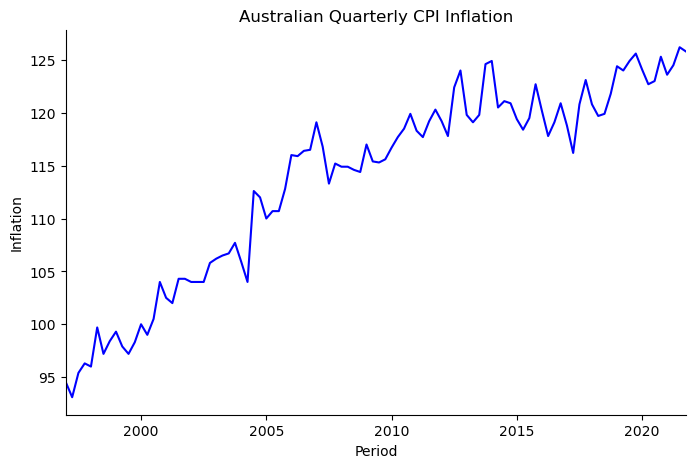

In [13]:
y = clean_CPI_train_data['CPI']

fig, ax = plt.subplots(figsize=(8, 5))
y.plot(color='b', ax=ax)
ax.set_xlabel('Period')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Time Series Decomposition

In [14]:
window_size = 12    
decomposition = seasonal_decompose(y, model='additive', period=4, filt=np.repeat(1/window_size, window_size))

In [15]:
decomposition.seasonal.tail()

Quarter
2020Q4    0.894602
2021Q1    0.243466
2021Q2   -0.937595
2021Q3   -0.200473
2021Q4    0.894602
Freq: Q-DEC, Name: seasonal, dtype: float64

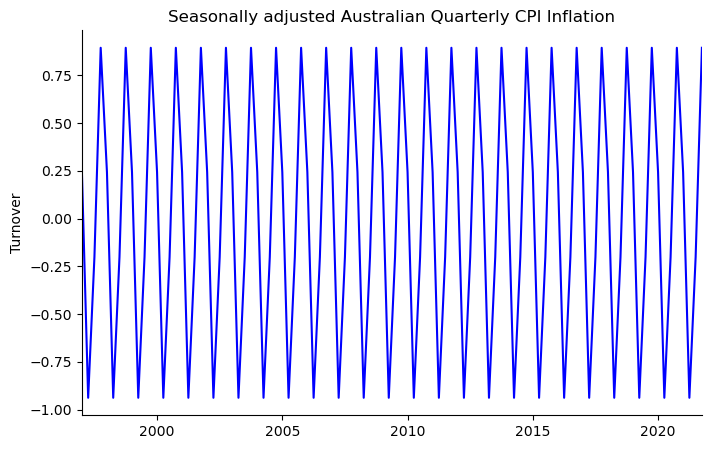

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
decomposition.seasonal.plot(color='blue', ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Seasonally adjusted Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

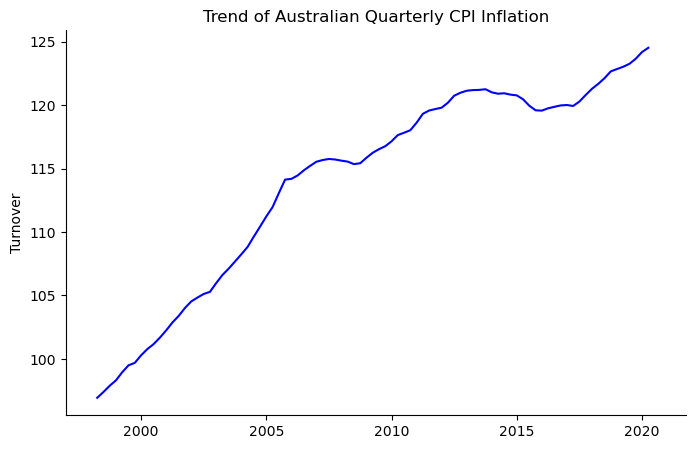

In [17]:
fig, ax = plt.subplots(figsize=(8, 5))
decomposition.trend.plot(color="blue", ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Trend of Australian Quarterly CPI Inflation')
# I prefer to remove the minor ticks for a cleaner plot
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

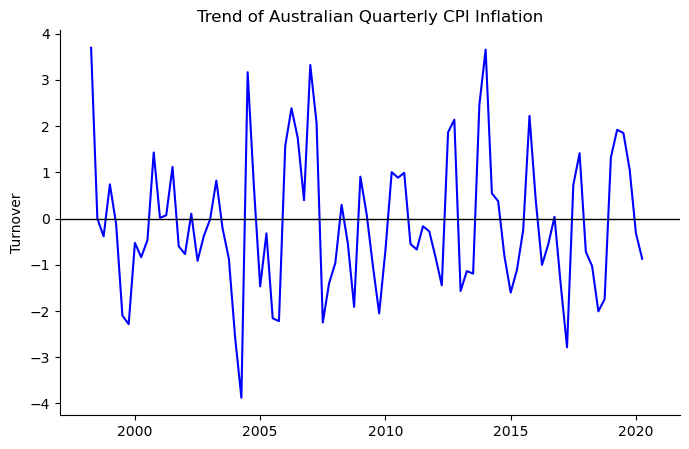

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))
decomposition.resid.plot(color='blue', ax=ax)
ax.axhline(0, color='black', lw=1)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Trend of Australian Quarterly CPI Inflation')
ax.set_xticks([], minor=True)
sns.despine()
plt.show()

## Testing for Stationary Points

**Hypothesis Testing** using **Augmented Dickey-Fuller**

**Formula:** 

\begin{align*}
\boldsymbol{\Delta} y_t = \boldsymbol{\alpha} + \boldsymbol{\beta} t + \boldsymbol{\gamma} y_{t-1} + \boldsymbol{\delta}_1 \boldsymbol{\Delta} y_{t-1} \dots + \boldsymbol{\delta}_{p-1} \boldsymbol{\Delta} y_{t-p+1} + \boldsymbol{\epsilon}_t,
\end{align*}


where $\boldsymbol{\alpha}$ is a constant term,  $\boldsymbol{\beta} t$ is the trend coefficient, $\boldsymbol{\gamma} y_{t-1}$ is the coefficient of the lagged level of time series, $\boldsymbol{\delta}_i$ are the coefficients of the lagged differences, $t$ is the time index, $p$ is the number of lags, and $\boldsymbol{\epsilon}_t$ is the error term  

$H_0:$ The time series is non-stationary.


$H_A:$ The time series is stationary.


**Threshold:**


$\alpha = 0.05$

In [19]:
adf_test = adfuller(CPI_train_data['CPI'], autolag='t-stat')
print(f'ADF P-value: {round(adf_test[1], 4)}')

ADF P-value: 0.212


Since the p-value $> 0.05$ ($\alpha$), we fail to reject the null hypothesis which suggests that the time series is non-stationary.  Hence, we will be using model smoothing to forecast the future predictions of the Australian CPI Inflation. 

# Model Smoothing

## Simple Exponential Smoothing 

In [20]:
simple_exponential_smoothing = SimpleExpSmoothing(y, initialization_method="estimated")
fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(optimized=True)
fitted_simple_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,SimpleExpSmoothing,SSE,388.993
Optimized:,True,AIC,139.839
Trend:,None,BIC,145.049
Seasonal:,None,AICC,140.260
Seasonal Periods:,None,Date:,"Tue, 22 Oct 2024"
Box-Cox:,False,Time:,10:44:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6496116,alpha,True
initial_level,94.341806,l.0,True


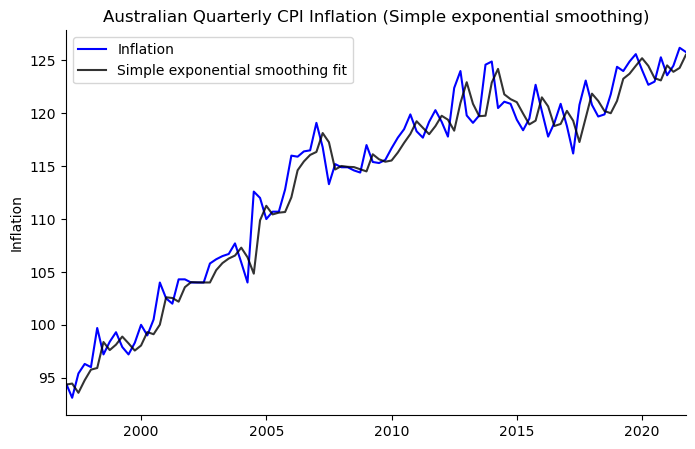

In [21]:
fig, ax = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
simple_exponential_smoothing_fitted = fitted_simple_exponential_smoothing.fittedvalues
simple_exponential_smoothing_fitted.plot(
    color='black', label='Simple exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation (Simple exponential smoothing)')
ax.set_xticks([], minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Model Diagnostics

#### Residual Plot

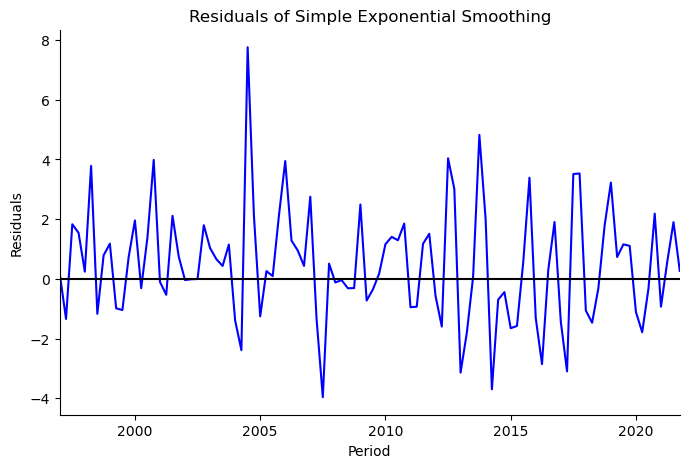

In [22]:
simple_exponential_smoothing_resid = y-simple_exponential_smoothing_fitted

fig, ax = plt.subplots(figsize=(8, 5))
simple_exponential_smoothing_resid.plot(color='b', ax=ax)
ax.set_xlabel('Period')
ax.set_ylabel('Residuals')
ax.set_title('Residuals of Simple Exponential Smoothing')
ax.set_xticks([], minor=True)
sns.despine()
plt.axhline(0, color='black')
plt.show()

#### Autocorrelation Plot

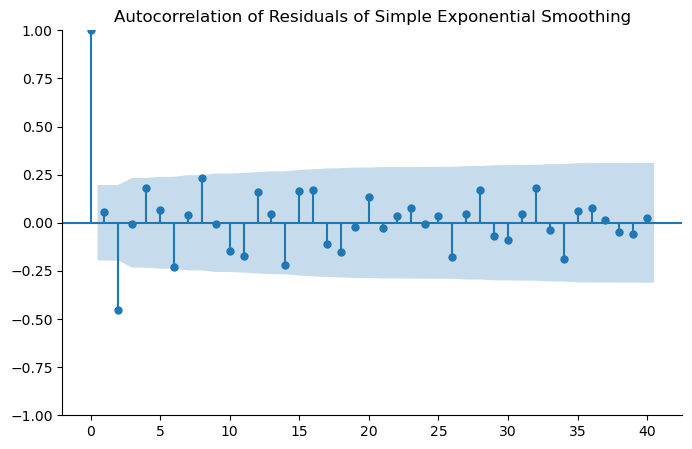

In [23]:
fig, ax = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(simple_exponential_smoothing_resid, lags=40, ax=ax)
sns.despine()
plt.title('Autocorrelation of Residuals of Simple Exponential Smoothing')
plt.show()

#### Histogram Plot

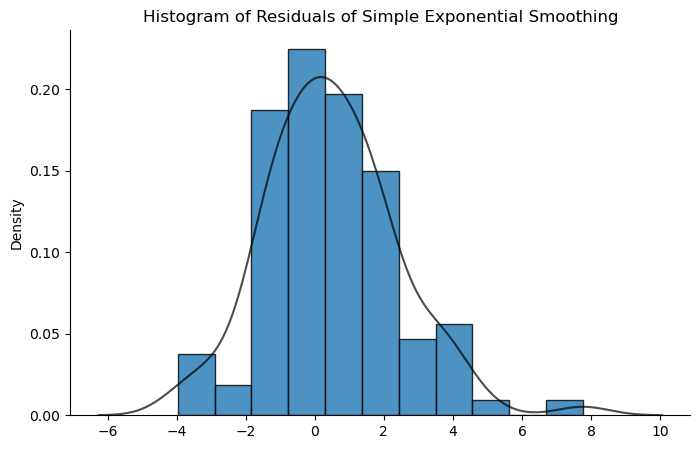

In [24]:
histogram(simple_exponential_smoothing_resid)
plt.title('Histogram of Residuals of Simple Exponential Smoothing')
plt.show()

#### QQ-plot

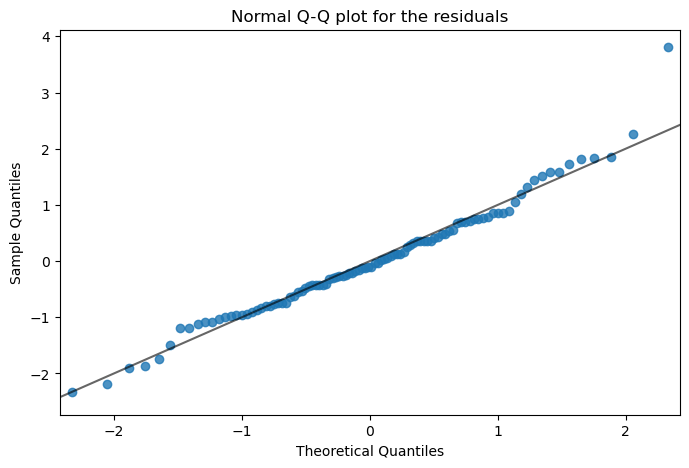

In [25]:
qq_plot(simple_exponential_smoothing_resid)
plt.show()

### Forecast

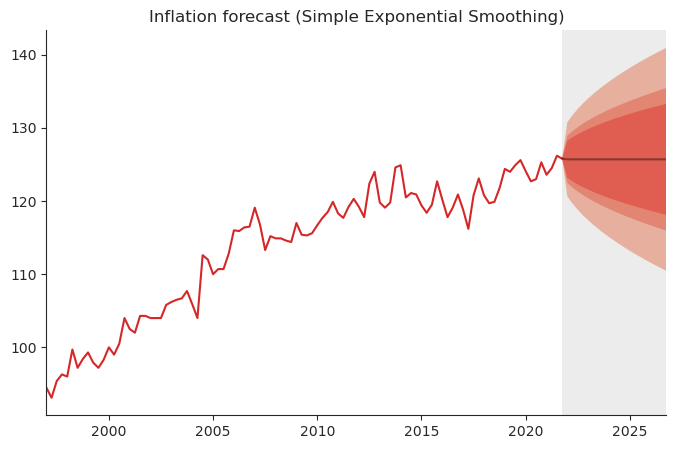

In [26]:
horizon = 20

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    fitted_simple_exponential_smoothing.forecast(horizon), index=test)

intv1 = pd.DataFrame(intervalforecast(
    fitted_simple_exponential_smoothing, horizon, level=.8), index=test)
intv2 = pd.DataFrame(intervalforecast(
    fitted_simple_exponential_smoothing, horizon, level=.9), index=test)
intv3 = pd.DataFrame(intervalforecast(
    fitted_simple_exponential_smoothing, horizon, level=.99), index=test)

fig, ax = fanchart(y, pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Inflation forecast (Simple Exponential Smoothing)')

sns.despine()
plt.show()

## Holt Exponential Smoothing

In [27]:
holt_exponential_smoothing = Holt(y, initialization_method="estimated")
fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(optimized=True)
fitted_holt_exponential_smoothing.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,Holt,SSE,357.486
Optimized:,True,AIC,135.393
Trend:,Additive,BIC,145.813
Seasonal:,None,AICC,136.296
Seasonal Periods:,None,Date:,"Tue, 22 Oct 2024"
Box-Cox:,False,Time:,10:44:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.4700246,alpha,True
smoothing_trend,0.000000,beta,True


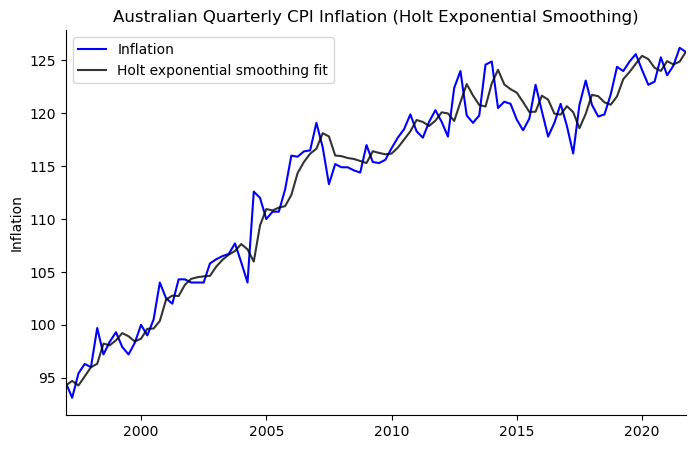

In [28]:
fig, ax = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
holt_exponential_smoothing_resid_fitted = fitted_holt_exponential_smoothing.fittedvalues
holt_exponential_smoothing_resid_fitted.plot(color='black', label='Holt exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation (Holt Exponential Smoothing)')
ax.set_xticks([], minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Model Diagnostics

#### Residual Plot

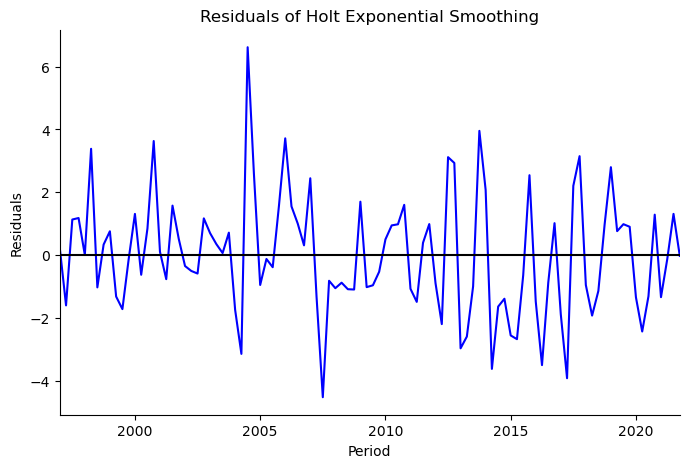

In [29]:
holt_exponential_smoothing_resid = y-holt_exponential_smoothing_resid_fitted

fig, ax = plt.subplots(figsize=(8, 5))
holt_exponential_smoothing_resid.plot(color='b', ax=ax)
ax.set_xlabel('Period')
ax.set_ylabel('Residuals')
ax.set_title('Residuals of Holt Exponential Smoothing')
ax.set_xticks([], minor=True)
sns.despine()
plt.axhline(0, color='black')
plt.show()

#### Autocorrelation Plot

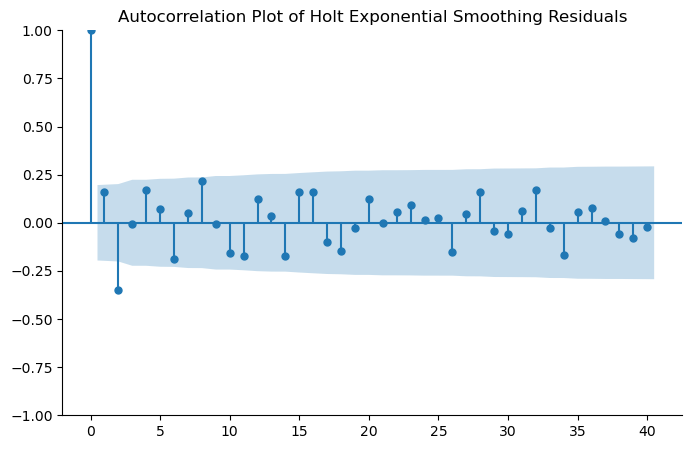

In [30]:
fig, ax = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(holt_exponential_smoothing_resid, lags=40, ax=ax)
sns.despine()
plt.title('Autocorrelation Plot of Holt Exponential Smoothing Residuals')
plt.show()

#### Histogram Plot

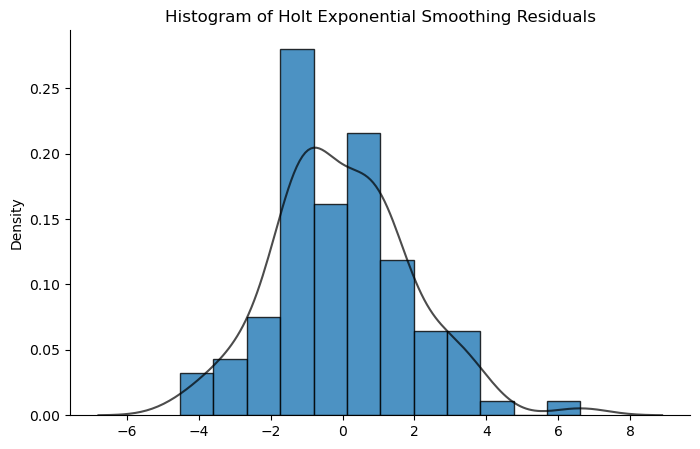

In [31]:
histogram(holt_exponential_smoothing_resid)
plt.title('Histogram of Holt Exponential Smoothing Residuals')
plt.show()

#### QQ-plot

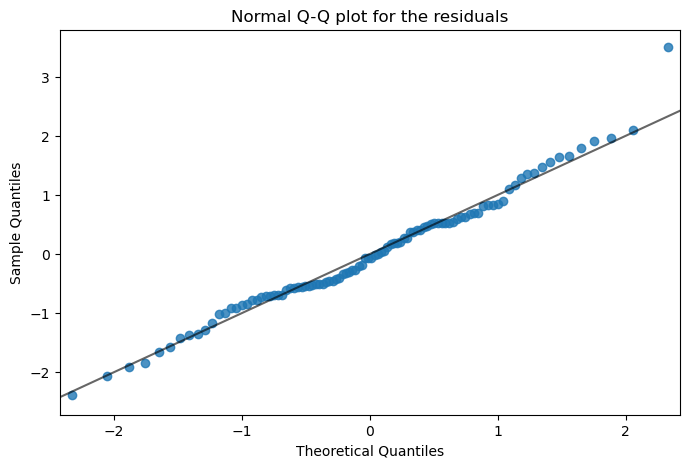

In [32]:
qq_plot(holt_exponential_smoothing_resid)
plt.show()

### Forecast

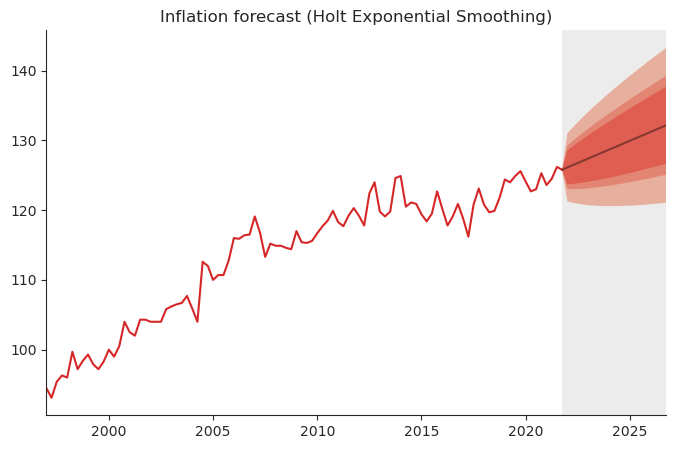

In [33]:
horizon = 20

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    fitted_holt_exponential_smoothing.forecast(horizon), index=test)

intv1 = pd.DataFrame(intervalforecast(
    fitted_holt_exponential_smoothing, horizon, level=.8), index=test)
intv2 = pd.DataFrame(intervalforecast(
    fitted_holt_exponential_smoothing, horizon, level=.9), index=test)
intv3 = pd.DataFrame(intervalforecast(
    fitted_holt_exponential_smoothing, horizon, level=.99), index=test)

fig, ax = fanchart(y, pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Inflation forecast (Holt Exponential Smoothing)')

sns.despine()
plt.show()

## Holt-Winters Exponential Smoothing

In [34]:
ahw=ExponentialSmoothing(y, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()
ahw.summary()

Dep. Variable:,CPI,No. Observations:,100
Model:,ExponentialSmoothing,SSE,291.201
Optimized:,True,AIC,122.884
Trend:,Additive,BIC,143.726
Seasonal:,Additive,AICC,125.356
Seasonal Periods:,4,Date:,"Tue, 22 Oct 2024"
Box-Cox:,False,Time:,10:44:46
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.5691148,alpha,True
smoothing_trend,4.7635e-10,beta,True


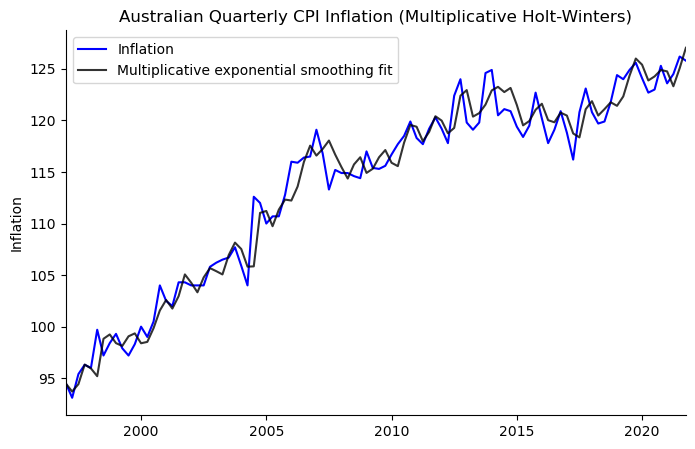

In [35]:
fig, ax = plt.subplots(figsize=(8, 5))
y.plot(color='b', label='Inflation')
ahw_fitted = ahw.fittedvalues
ahw_fitted.plot(
    color='black', label='Multiplicative exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation (Multiplicative Holt-Winters)')
ax.set_xticks([], minor=True)
plt.legend(loc='best')
sns.despine()
plt.show()

### Model Diagnostic

#### Residual Plot

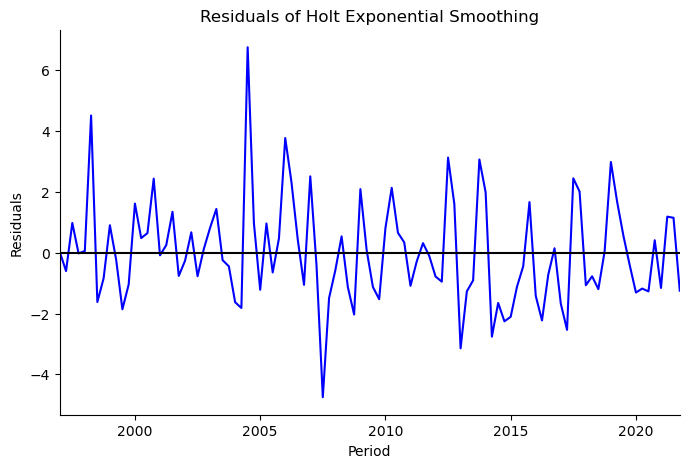

In [36]:
ahw_resid = y-ahw_fitted

fig, ax = plt.subplots(figsize=(8, 5))
ahw_resid.plot(color='b', ax=ax)
ax.set_xlabel('Period')
ax.set_ylabel('Residuals')
ax.set_title('Residuals of Holt Exponential Smoothing')
ax.set_xticks([], minor=True)
sns.despine()
plt.axhline(0, color='black')
plt.show()

#### Autocorrelation Plot

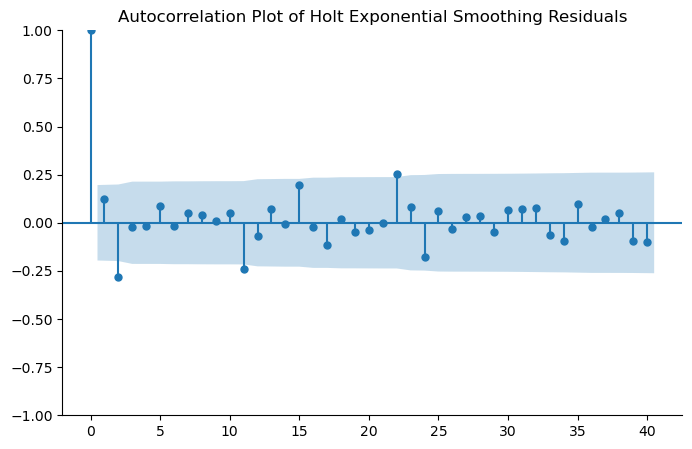

In [37]:
fig, ax = plt.subplots(figsize=(8, 5))
sm.graphics.tsa.plot_acf(ahw_resid, lags=40, ax=ax)
sns.despine()
plt.title('Autocorrelation Plot of Holt Exponential Smoothing Residuals')
plt.show()

#### Histogram Plot

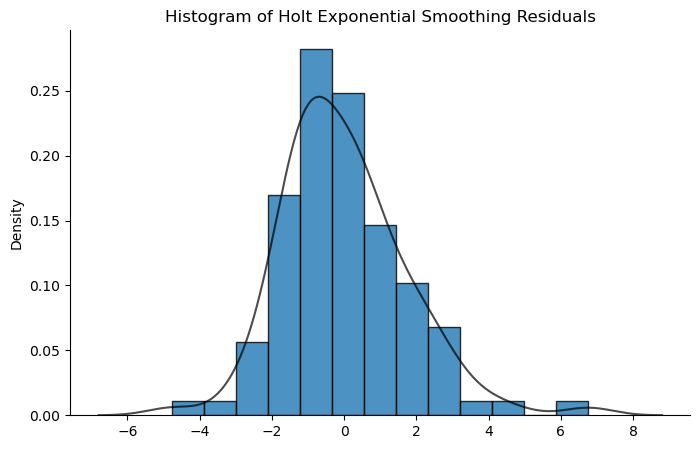

In [38]:
histogram(ahw_resid)
plt.title('Histogram of Holt Exponential Smoothing Residuals')
plt.show()

#### QQ-plot

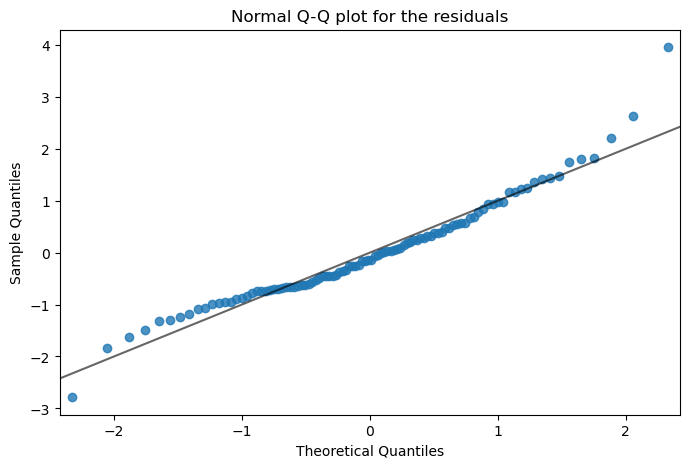

In [39]:
qq_plot(ahw_resid)
plt.show()

### Forecast

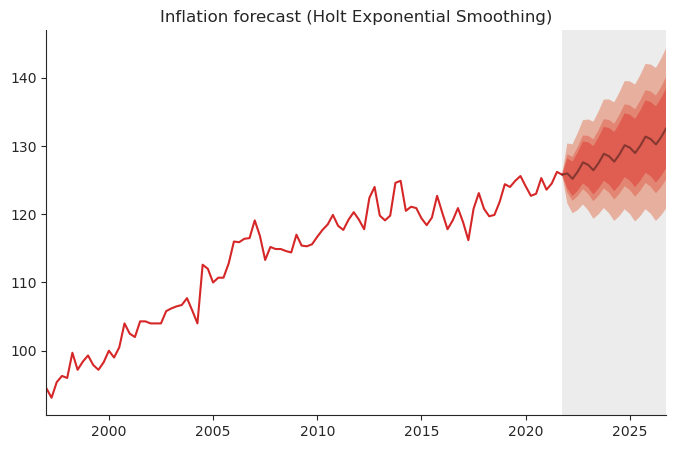

In [40]:
horizon = 20

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    ahw.forecast(horizon), index=test)

intv1 = pd.DataFrame(intervalforecast(
    ahw, horizon, level=.8), index=test)
intv2 = pd.DataFrame(intervalforecast(
    ahw, horizon, level=.9), index=test)
intv3 = pd.DataFrame(intervalforecast(
    ahw, horizon, level=.99), index=test)

fig, ax = fanchart(y, pred, intv1, intv2, intv3)
ax.set_xlabel('')
ax.set_xticks([], minor=True)
plt.title('Inflation forecast (Holt Exponential Smoothing)')

sns.despine()
plt.show()

## Model Training

### Splitting Data into Training and Validation Sets

In [41]:
X = clean_CPI_train_data.drop('CPI', axis=1)
y = clean_CPI_train_data['CPI']

tss = TimeSeriesSplit(n_splits=3)

for train_index, val_index in tss.split(X):
    X_train, X_val = X.iloc[train_index, :], X.iloc[val_index, :]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

MSE of Simple Exponential Smoothing: 15.6437
MSE of Holt Exponential Smoothing: 7.1916
MSE of Holt-Winters Exponential Smoothing: 7.0358


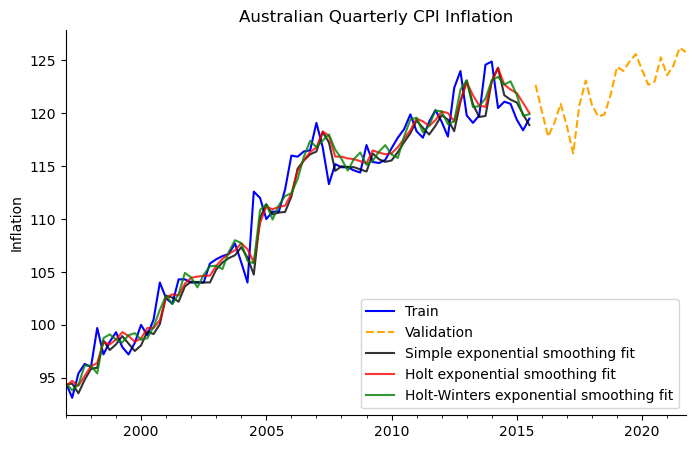

In [55]:
# Simple Exponential Smoothing
simple_exponential_smoothing = SimpleExpSmoothing(
    y_train, initialization_method="estimated")

fitted_simple_exponential_smoothing = simple_exponential_smoothing.fit(
    optimized=True)

# Holt Exponential Smoothing
holt_exponential_smoothing = Holt(
    y_train, initialization_method="estimated")

fitted_holt_exponential_smoothing = holt_exponential_smoothing.fit(
    optimized=True)

# Holt-Winters Exponential Smoothing
ahw = ExponentialSmoothing(
    y_train, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()

# Calculate MSE

# Simple Exponential Smoothing
y_pred = fitted_simple_exponential_smoothing.forecast(len(y_val))
mse_simple_exponential_smoothing = mean_squared_error(y_val, y_pred)

# Holt Exponential Smoothing
y_pred = fitted_holt_exponential_smoothing.forecast(len(y_val))
mse_holt_exponential_smoothing = mean_squared_error(y_val, y_pred)

# Holt-Winters Exponential Smoothing
y_pred = ahw.forecast(len(y_val))
mse_ahw = mean_squared_error(y_val, y_pred)

print(f'MSE of Simple Exponential Smoothing: {round(mse_simple_exponential_smoothing, 4)}')
print(f'MSE of Holt Exponential Smoothing: {round(mse_holt_exponential_smoothing, 4)}')
print(f'MSE of Holt-Winters Exponential Smoothing: {round(mse_ahw, 4)}')

# Plot the predictions of each model.  
fig, ax = plt.subplots(figsize=(8, 5))
y_train.plot(color='blue', label='Train')
y_val.plot(color='orange', label='Validation', linestyle='--')
fitted_simple_exponential_smoothing.fittedvalues.plot(
    color='black', label='Simple exponential smoothing fit', alpha=0.8)
fitted_holt_exponential_smoothing.fittedvalues.plot(
    color='red', label='Holt exponential smoothing fit', alpha=0.8)
ahw.fittedvalues.plot(color='green', label='Holt-Winters exponential smoothing fit', alpha=0.8)
ax.set_xlabel('')
ax.set_ylabel('Inflation')
ax.set_title('Australian Quarterly CPI Inflation')
plt.legend(loc='best')
sns.despine()
plt.show()

# Picking Best Smoothing Model

In [43]:
ahw = ExponentialSmoothing(y, seasonal_periods=4, trend="add", seasonal="add", initialization_method="estimated").fit()

horizon = 8

test = pd.period_range(
    start=y.index[-1] + 1, periods=horizon, freq='Q')

pred = pd.Series(
    ahw.forecast(horizon), index=test).round(4)


CPI_forecast = pd.DataFrame(pred, columns=['CPI'])
CPI_forecast.index.name = 'Quarter'
CPI_forecast.to_csv('CPI_forecast.csv')

CPI_forecast

,CPI
Quarter,
2022Q1,125.9747
2022Q2,125.1907
2022Q3,126.2547
2022Q4,127.5986
2023Q1,127.2346
2023Q2,126.4506
2023Q3,127.5146
2023Q4,128.8586


# Code Chunk to Run Tests for Predictions

In [44]:
# CPI_test = pd.read_csv('CPI_test.csv')
# test_error = mean_squared_error(CPI_test['CPI'], CPI_forecast['CPI'])
# print (test_error)